In [1]:
using LinearAlgebra
using Plots
using QuadGK
using DifferentialEquations
using LaTeXStrings
using FFTW
using Statistics
using SteadyStateDiffEq
using NLsolve
LinearAlgebra.BLAS.set_num_threads(1)

Base.@kwdef struct Parameters{T}
    J::T
    g::T
    γ::T
    κ::T
    β::T
    α::T
   M::T
    Γu::T
    Γd::T
    p::T
end

In [2]:
function δ(n,m)
    if n == m
        return 1
    else 
        return 0 
    end
end

δ (generic function with 1 method)

In [3]:
function k1!(du,u,s,t) ## Single cavity with 4 equations ## including the delta term 
    
    (; α, β, J, M, p, Γu, Γd, κ, g, γ) = s
    
        a = @views u[1] #Ψ
        E = @views u[2] #<σz>
        χ = @views u[3] #<σ->
        n = @views u[4] #<a†a>
    
    du[1] = -1im * g * M * χ - (κ/2) * a - ((α - β)/4) * M * a + ((α + β)/ 4) * M * a * E
    
    du[2] = real(2 * 1im * g * (conj(a) * χ - a * conj(χ)) + (Γu - Γd - β) - (Γu + Γd + β) * E + (α - β) * n - (α + β) * n * E)   
    
    du[3] = 1im * g * a * E - ((Γu + Γd + β)/2) * χ - ((α + β)/2) * n * χ
    
    du[4] = -1im * g * M * (conj(a) * χ - a * conj(χ)) - κ * n + β/2 * M * (1 + E) - ((α - β)/2) * M * n + ((α + β)/2) * M * n * E
        
end 

k1! (generic function with 1 method)

In [4]:
function k2!(du,u,s,t) ## Single cavity with 8 equations 
    
    (; α, β, J, M, p, Γu, Γd, κ, g, γ) = s
    
        a = @views u[1] #Ψ
        E = @views u[2] #<σz>
        χ = @views u[3] #<σ->
        n = @views u[4] #<a†a>
        Δ = @views u[5] #<aa>
        y = @views u[6] #<aσ+>
        ρ = @views u[7] #<aσ_>
        z = @views u[8] #<aσ_z>
    
    du[1] = -1im * g * M * χ - (κ/2) * a - ((α - β)/4) * M * a + ((α + β)/ 4) * M * z
    
    du[2] = real(2 * 1im * g * (conj(y) - y) + (Γu - Γd - β) - (Γu + Γd + β) * E + (α - β) * n - (α + β) * (conj(a) * z +
     a * conj(z) + n * E - 2 * conj(a) * a * E))
    
    du[3] = 1im * g * z - ((Γu + Γd + β)/2) * χ - ((α + β)/2) * (conj(a) * ρ + a * conj(y) + n * χ - 2 * conj(a) * a * χ)
    
    du[4] = -1im * g * M * (conj(y) - y) - κ * n + β/2 * M * (1 + E) - ((α - β)/2) * M * n + ((α + β)/2) * M * 
    (conj(a) * z + a * conj(z) + n * E - 2 * conj(a) * a * E)
    
    du[5] = -2 * 1im * g * M * ρ - κ * Δ - ((α - β)/2) * M * Δ + ((α + β)/2) * M * (2 * a * z + Δ * E - 2 * a^2 * E)
    
    du[6] = -1im * g * (M-1) * conj(χ) * χ - 0.5 * 1im * g * (1 - E)  - 1im * g * ((1 + n) * E + a * conj(z) +
     conj(a) * z - 2 * a * conj(a) * E) - 0.5 * (κ + Γu + Γd) * y - β * y - 0.5 * (α + β) * (2 * n * y + conj(ρ) * Δ -
     2 * a^2 * conj(a) * conj(χ)) - 0.25 * (α - β) * (M + 1) * y + 0.25 * (α + β) * (M-1) * (z * conj(χ) + y * E -
     a * E * conj(χ))
    
    du[7] = -1im * g * (M-1) * χ^2 + 1im * g * (2 * a * z + Δ * E - 2 * a^2 * E) - (κ + Γu + Γd)/2 * ρ - 0.5 * (α + β) * 
    (2 * n * ρ + Δ * conj(y) - 2 * a^2 * conj(a) * χ) - β * ρ - 0.25 * (α - β) * (M - 1) * ρ + 0.25 * (α + β) * (M - 1) *
    (ρ * E + z * χ - a * χ * E)
    
    du[8] = - 2 * 1im * g * (2 * a * y + Δ * conj(χ) - 2 * a^2 * conj(χ) - a * conj(y) - conj(a) * ρ - n * χ + 
     2 * a * conj(a) * χ + 0.5 * (M - 1) * E * χ - 0.5 * χ) - (κ/2) * z + (Γu - Γd) * a - (Γu + Γd) * z - 2 * β * (a + z) + 
    (α - β) * (conj(a) * Δ + 2 * a * n - 2 * conj(a) * a^2) - (α + β) * (2 * n * z + Δ * conj(z) - 2 * conj(a) * a^2 * E) + 
    0.25 * (α + β) * a - 0.25 * (α - β) * M * z + 0.25 * (α + β) * (M - 1) * (2 * z * E - a * E^2)
    
    
end 

k2! (generic function with 1 method)

In [6]:
a = [0.1+0.0im]
e = [0.0]
n = [10.0]
y = d = ρ = [0.0 + 0.0im];
z = ones(ComplexF64, 1,1) .* 10^-5;

x_lar = [1.0 + 0.0im]
x_sml = [0.0 + 0.0im];

In [54]:
    s = Parameters(J=0.0, g = 0.004, γ = 0.0, κ=1.0,  α=8.5e-5, β=8.5e-5, M=1.e4, Γu = 5.0, Γd=7e-4, p = 0.0)


    t_0 = 9000
    t_f = 10000
    dt = 0.1

    tspan = (0.0, t_f)

    saveat_times = range(t_0,t_f, step = dt)

    u0_lar = ArrayPartition(a, e, x_lar, n, d, y, ρ, z)
    u0_sml = ArrayPartition(a, e, x_sml, n, d, y, ρ, z)



    prob_lar = ODEProblem(k2!, u0_lar, tspan, s)
    prob_sml = ODEProblem(k2!, u0_sml, tspan, s)


    sol1  = solve(prob_lar, Tsit5(),reltol=1e-4, maxiters=1e8, saveat = saveat_times);
    sol2  = solve(prob_sml, Tsit5(),reltol=1e-4, maxiters=1e8, saveat = saveat_times);

     a_lar = hcat(mapreduce(x -> x.x[1], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     e_lar = real(hcat(mapreduce(x -> x.x[2], (x, y) -> cat(x, y, dims=3), sol1.u)...))
     x_lar = hcat(mapreduce(x -> x.x[3], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     n_lar = real(hcat(mapreduce(x -> x.x[4], (x, y) -> cat(x, y, dims=3), sol1.u)...))
     aa_lar = hcat(mapreduce(x -> x.x[5], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     y_lar = hcat(mapreduce(x -> x.x[6], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     r_lar = hcat(mapreduce(x -> x.x[7], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     z_lar = hcat(mapreduce(x -> x.x[8], (x, y) -> cat(x, y, dims=3), sol1.u)...)
     G_LC1_decond[24]s=3), sol2.u)...)
    n_sml = real(hcat(mapreduce(x -> x.x[4], (x, y) -> cat(x, y, dims=3), sol2.u)...))
    aa_sml = hcat(mapreduce(x -> x.x[5], (x, y) -> cat(x, y, dims=3), sol2.u)...)
    y_sml = hcat(mapreduce(x -> x.x[6], (x, y) -> cat(x, y, dims=3), sol2.u)...)
    r_sml = hcat(mapreduce(x -> x.x[7], (x, y) -> cat(x, y, dims=3), sol2.u)...)
    z_sml = hcat(mapreduce(x -> x.x[8], (x, y) -> cat(x, y, dims=3), sol2.u)...)


1×10001 Matrix{ComplexF64}:
 1.0e-5+0.0im  1.0e-5+0.0im  1.0e-5+0.0im  …  1.0e-5+0.0im  1.0e-5+0.0im

In [51]:
e_lar

1×10001 Matrix{Float64}:
 0.998316  0.998316  0.998316  0.998316  …  0.998316  0.998316  0.998316

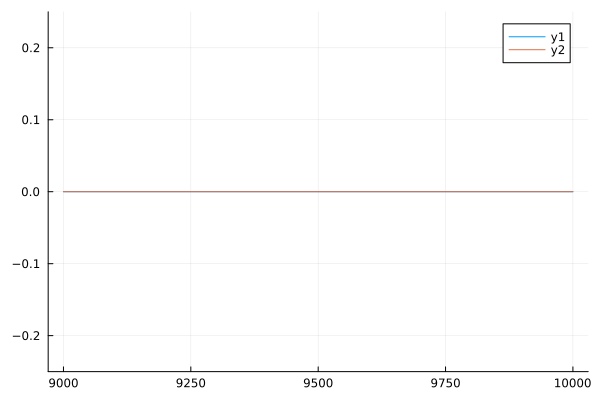

In [35]:
plot(sol1.t, abs2.(a_lar)')
plot!(sol2.t, abs2.(a_sml)')

ylims!(-0.25, 0.25)


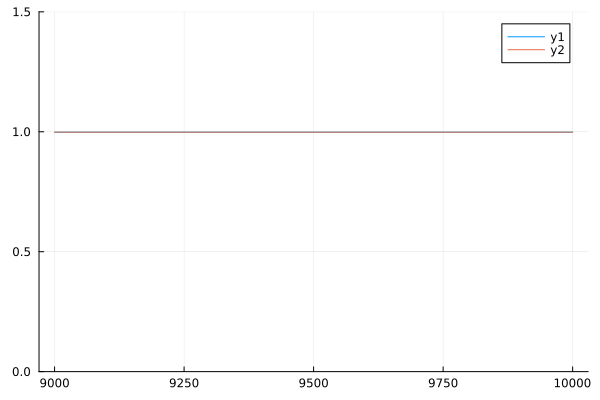

In [26]:
plot(sol1.t, e_lar')
plot!(sol2.t, e_sml')
ylims!(0.0,1.5)

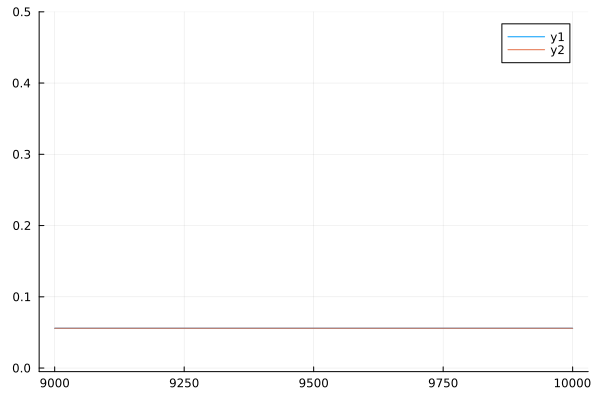

In [37]:
plot(sol1.t, abs.(y_lar)')
plot!(sol2.t, abs.(y_sml)')

ylims!(-0.005, 0.5)

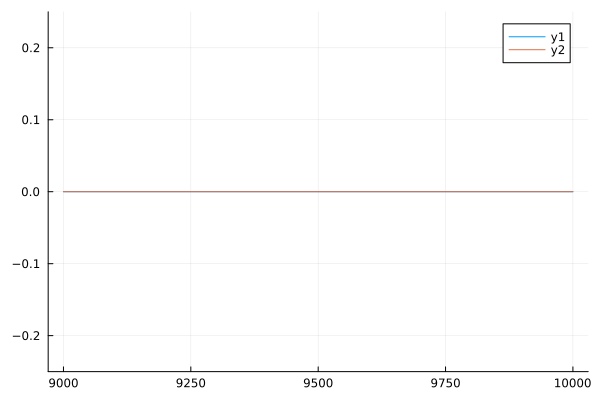

In [39]:
plot(sol1.t, abs.(x_lar)')
plot!(sol2.t, abs.(x_sml)')
ylims!(-0.25, 0.25)

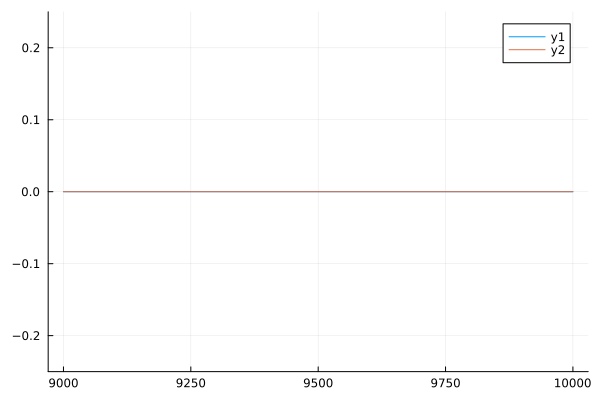

In [41]:
plot(sol1.t, abs.(z_lar)')
plot!(sol2.t, abs.(z_sml)')
ylims!(-0.25, 0.25)

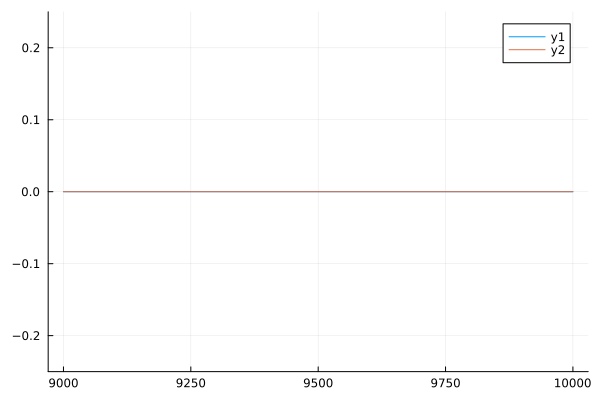

In [44]:
plot(sol1.t, abs.(aa_lar)')
plot!(sol2.t, abs.(aa_sml)')
ylims!(-0.25, 0.25)

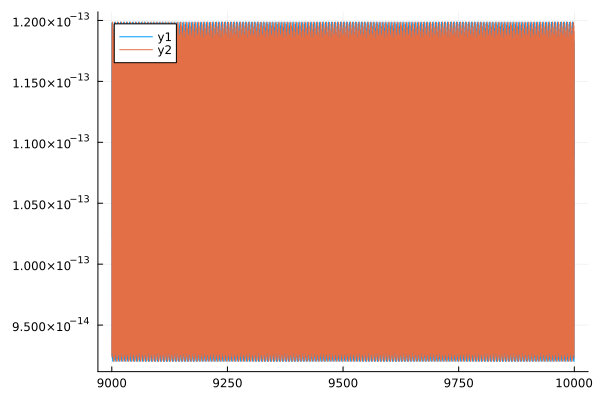

In [45]:
plot(sol1.t, abs.(r_lar)')
plot!(sol2.t, abs.(r_sml)')

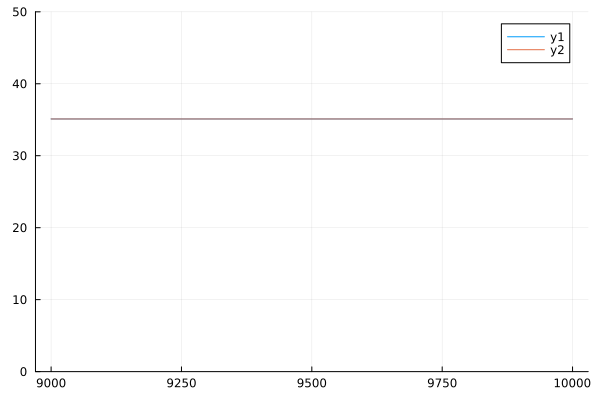

In [47]:
plot(sol1.t, n_lar')
plot!(sol2.t, n_sml')
ylims!(0.0,50)